In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, pool2graph, evaluation, discrepancies_intervals, pool2graph_cat_FJ2_2, pool2graph_reg

RANDOM_STATE = 42

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# imports pricing

from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys
print(sys.argv)
import os
import urllib
import os.path
import sklearn.preprocessing as preprocessing
from collections import namedtuple
import pandas as pd

['/Users/b076rg/opt/anaconda3/envs/python_env/lib/python3.9/site-packages/ipykernel_launcher.py', '-f', '/Users/b076rg/Library/Jupyter/runtime/kernel-fcefff6f-7560-4833-a9b0-3b0998f7c4f4.json']


In [3]:
!wget "http://grarivincent.com/research/baseINSEE.csv"

--2021-10-27 16:15:43--  http://grarivincent.com/research/baseINSEE.csv
Résolution de grarivincent.com (grarivincent.com)… 217.160.0.183
Connexion à grarivincent.com (grarivincent.com)|217.160.0.183|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 5107089 (4,9M) [text/csv]
Sauvegarde en : « baseINSEE.csv.2 »

baseINSEE.csv.2     100%[===================>]   4,87M  7,57MB/s    ds 0,6s    

2021-10-27 16:15:44 (7,57 MB/s) — « baseINSEE.csv.2 » sauvegardé [5107089/5107089]



In [4]:
baseINSEE = (pd.read_csv("baseINSEE.csv", #names=column_names,
                    sep=r'\s*;\s*', engine='python', na_values=['NA']))
baseINSEE['pol_insee_code']= baseINSEE['code_commune_INSEE']

In [14]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))
def load_ICU_Pricing(path):
    #column_names = ["CalYear","Gender","Type","Category","Occupation","Age","Group1","Bonus","Poldur","Value","Adind","SubGroup2","Group2","Density","Y"]
    #input_data = (pd.read_csv(path, #names=column_names,
    #                           sep=r',', engine='python', keep_default_na=False, na_values=['NA']))
    
    path = "http://grarivincent.com/research/db4ModelFull2.csv"
    input_data = (pd.read_csv(path, #names=column_names,
                                sep=r',', engine='python', na_values=['NA']))
    input_data=input_data.drop(columns=['Unnamed: 0'])
    
    base=baseINSEE
    base = base[~base.pol_insee_code.str[:2].isin(["2A","2B"])]
    base["pol_insee_code"] = base["pol_insee_code"].astype(int)
    base_nd =  base.drop_duplicates(subset=['pol_insee_code'])

    input_data = input_data.drop_duplicates()
    input_data = input_data[~input_data.pol_insee_code.str[:2].isin(["2A","2B"])]
    input_data["pol_insee_code"] = input_data["pol_insee_code"].astype(int)

    input_data = input_data.merge(base_nd, how='inner', on="pol_insee_code")
    #input_data = input_data[input_data['claim_amount']<=5000]
    #input_data=input_data[input_data['claim_amount']!=0]
   
    #
    sensitive_attribs = ['Age']
    print(input_data.shape)
    G0 = (input_data.iloc[:, 37:180]) #137])
    #Z0 = pd.concat(Z0,input_data['long'])
    G0=G0.select_dtypes([np.number])
    G0 = G0.fillna(G0.mean())
    G=G0
    #Z = (Z0
    #    .drop(columns=['"REG"'
    #                   ])
    #    .fillna('Unknown').pipe(pd.get_dummies))

    y = input_data['claim_amount']
    E  = input_data['exposure']
    #I = input_data["pol_insee_code"]
    I = input_data[['pol_insee_code','latitude','longitude']]

    # features; note that the 'target' and sentive attribute columns are dropped
    X0 = input_data.iloc[:, 4:31]
    
    X = (X0
          .drop(columns=['pol_coverage','pol_insee_code'])
          .fillna('Unknown').pipe(pd.get_dummies))
    INSEE = input_data.iloc[:, 36]
    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape[0]} samples")
    print(f"sensitives E: {E.shape[0]} samples, {E.shape[0]} attributes")
    return X, y, G, E, I

X, y, G, E, I =load_ICU_Pricing("http://grarivincent.com/research/db4modelfull3.csv")

(98417, 151)
features X: 98417 samples, 1157 attributes
targets y: 98417 samples
sensitives E: 98417 samples, 98417 attributes


In [20]:
X=X[y>0]
G=G[y>0]
E=E[y>0]
I=I[y>0]
y=y[y>0]
G= G.iloc[:, :-5]

In [29]:
#JAI ENLEVE
cols_to_keep = X.columns
cols_to_keep = [c for c in cols_to_keep if 'vh_model' not in c]
cols_to_keep = [c for c in cols_to_keep if 'vh_make' not in c]
cols_to_keep = [c for c in cols_to_keep if 'vh_fuel' not in c]
cols_to_keep = [c for c in cols_to_keep if 'vh_type' not in c]
#cols_to_keep = [c for c in cols_to_keep if 'drv' not in c]
X2 = X[cols_to_keep]
print(cols_to_keep)

print(X.shape)
X_train, X_test, y_train, y_test, G_train, G_test, E_train, E_test, I_train, I_test  = train_test_split(X2, y, G, E, I, test_size=0.5, random_state=7)

['pol_bonus', 'pol_duration', 'pol_sit_duration', 'drv_age1', 'drv_age2', 'drv_age_lic1', 'drv_age_lic2', 'vh_age', 'vh_cyl', 'vh_din', 'vh_sale_begin', 'vh_sale_end', 'vh_speed', 'vh_value', 'vh_weight', 'pol_pay_freq_Biannual', 'pol_pay_freq_Monthly', 'pol_pay_freq_Quarterly', 'pol_pay_freq_Yearly', 'pol_payd_No', 'pol_payd_Yes', 'pol_usage_Professional', 'pol_usage_Retired', 'pol_usage_WorkPrivate', 'drv_drv2_No', 'drv_drv2_Yes', 'drv_sex1_F', 'drv_sex1_M', 'drv_sex2_F', 'drv_sex2_M', 'drv_sex2_Unknown']
(11025, 1157)


In [30]:
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler)

scalerg = StandardScaler().fit(G_train)
scale_df_g = lambda df, scaler: pd.DataFrame(scalerg.transform(df), columns=df.columns, index=df.index)
G_train = G_train.pipe(scale_df_g, scalerg) 
G_test = G_test.pipe(scale_df_g, scalerg)

## GLM Poisson Sans zonier

In [31]:
list(X_train.columns)

['pol_bonus',
 'pol_duration',
 'pol_sit_duration',
 'drv_age1',
 'drv_age2',
 'drv_age_lic1',
 'drv_age_lic2',
 'vh_age',
 'vh_cyl',
 'vh_din',
 'vh_sale_begin',
 'vh_sale_end',
 'vh_speed',
 'vh_value',
 'vh_weight',
 'pol_pay_freq_Biannual',
 'pol_pay_freq_Monthly',
 'pol_pay_freq_Quarterly',
 'pol_pay_freq_Yearly',
 'pol_payd_No',
 'pol_payd_Yes',
 'pol_usage_Professional',
 'pol_usage_Retired',
 'pol_usage_WorkPrivate',
 'drv_drv2_No',
 'drv_drv2_Yes',
 'drv_sex1_F',
 'drv_sex1_M',
 'drv_sex2_F',
 'drv_sex2_M',
 'drv_sex2_Unknown']

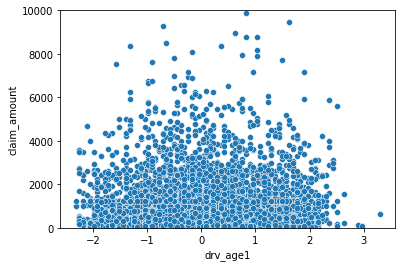

<AxesSubplot:xlabel='drv_age1', ylabel='Density'>

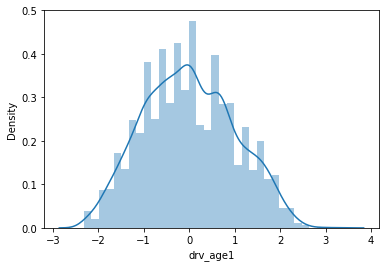

In [63]:
column = 'drv_age1'
sns.scatterplot(X_train[column], y_train)
plt.ylim((0.0, 10000))
plt.show()

sns.distplot(X_train[column])

In [68]:
from sklearn import linear_model
reg1 = linear_model.GammaRegressor()
reg1.fit(X_train,y_train)


FEATURE = "drv_age1"
THRESHOLD = 0.8

reg21 = linear_model.GammaRegressor()
reg22 = linear_model.GammaRegressor()
XtrainA = X_train[X_train[FEATURE] < THRESHOLD]
XtrainB = X_train[X_train[FEATURE] >= THRESHOLD]
#XtrainB[FEATURE] = np.zeros(XtrainB.shape[0])
#XtrainB = np.zeros(XtrainB.shape)
ytrainA = y_train[X_train[FEATURE] < THRESHOLD]
ytrainB = y_train[X_train[FEATURE] >= THRESHOLD]
reg21.fit(XtrainA,ytrainA)
reg22.fit(XtrainB,ytrainB)

class reg2clf():
    def __init__(self):
        1
        
    def predict(self, X):
        X = pd.DataFrame(X, columns = X_train.columns)
        
        XA = X[X[FEATURE] < THRESHOLD]
        XB = X[X[FEATURE] >= THRESHOLD]
        
        try:
            predA = pd.Series(reg21.predict(XA), index=XA.index)
        except ValueError:
            predA = pd.Series([])
        try:
            predB = pd.Series(reg22.predict(XB), index=XB.index)
        except ValueError:
            predB = pd.Series([])
        
        predEnd = predA.append(predB)
        
        index_ordered = pd.DataFrame(range(X.shape[0]), columns=['pos'], index=X.index)
        predEnd = predEnd.sort_index(key=lambda x: index_ordered.loc[x]['pos'])
        
        return predEnd.values
        
    def score(self, X, y):
        XA = X[X[FEATURE] < THRESHOLD]
        XB = X[X[FEATURE] >= THRESHOLD]
        yA = y[X[FEATURE] < THRESHOLD]
        yB = y[X[FEATURE] >= THRESHOLD]
        return reg21.score(XA, yA), reg22.score(XB, yB)
        
        
reg2 = reg2clf()
        
print(reg1.score(X_train,y_train), reg2.score(X_train,y_train))

0.023614258974896885 (0.02511312414355804, 0.038431544094896575)


In [69]:
        
def EDR_GAMMA(yhat, y):
    #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
    #loss=torch.mean(yhat-y*torch.log(yhat))
    eps=0.000000000001
    res=1-np.mean(-np.log(y/yhat)+(y-yhat)/yhat)/np.mean(-np.log(y/np.mean(y))+(y-np.mean(y))/np.mean(y))
    return res

def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

print(" GINI train : ", gini_coefficient(reg1.predict(X_train)))
print(" GINI test : ", gini_coefficient(reg1.predict(X_test)))
print(" EDR POIS train : ", EDR_GAMMA(reg1.predict(X_train),y_train))
print(" EDR POIS test : ", EDR_GAMMA(reg1.predict(X_test),y_test))
MSE_Poi_tr =  ((reg1.predict(X_train)-y_train)**2).mean()
MSE_Poi_test =  ((reg1.predict(X_test)-y_test)**2).mean()
print(" MSE Poi train : ", MSE_Poi_tr)
print(" MSE Poi test : ", MSE_Poi_test)

print('------ model2')

print(" GINI train : ", gini_coefficient(reg2.predict(X_train)))
print(" GINI test : ", gini_coefficient(reg2.predict(X_test)))
print(" EDR POIS train : ", EDR_GAMMA(reg2.predict(X_train),y_train))
print(" EDR POIS test : ", EDR_GAMMA(reg2.predict(X_test),y_test))
MSE_Poi_tr =  ((reg2.predict(X_train)-y_train)**2).mean()
MSE_Poi_test =  ((reg2.predict(X_test)-y_test)**2).mean()
print(" MSE Poi train : ", MSE_Poi_tr)
print(" MSE Poi test : ", MSE_Poi_test)

 GINI train :  0.06534856953403465
 GINI test :  0.0646863000812507
 EDR POIS train :  0.023614258974896885
 EDR POIS test :  0.01657807114415233
 MSE Poi train :  2876127.5500290357
 MSE Poi test :  10312277.07709674
------ model2
 GINI train :  0.0767518732708312
 GINI test :  0.07632784363254194
 EDR POIS train :  0.031141730535097056
 EDR POIS test :  0.016364950267781286
 MSE Poi train :  2862862.29263972
 MSE Poi test :  10314145.498521904


<AxesSubplot:xlabel='drv_age1'>

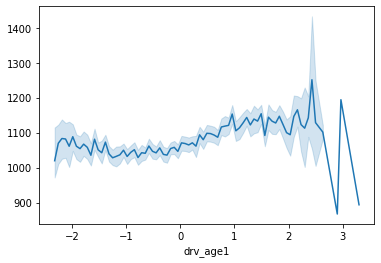

In [70]:
sns.lineplot(X_train[FEATURE], reg1.predict(X_train))

<AxesSubplot:xlabel='drv_age1'>

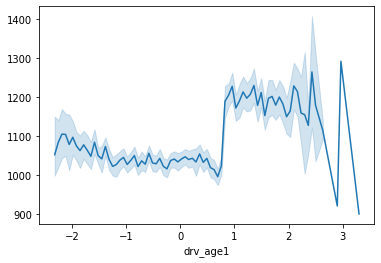

In [71]:
sns.lineplot(X_train[FEATURE], reg2.predict(X_train))

<AxesSubplot:ylabel='Density'>

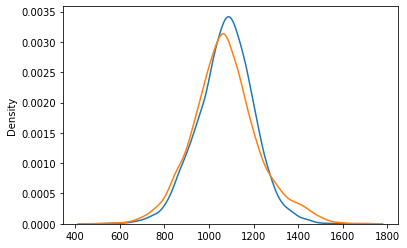

In [72]:
sns.kdeplot(reg1.predict(X_train), common_norm=True)
sns.kdeplot(reg2.predict(X_train), common_norm=True)



In [76]:
from sklearn import linear_model

### ICI on cree une classe de pool

class PricingPool():
    
    def __init__(self):
        self._model_types = ["gamma", "spline"]
        self.models = {}
        self.models["gamma"] = reg1
        self.models["spline"] = reg2
    
    def predict(self, X, mode='regression'):

        if mode == 'discrepancies':
            preds = self.predict_discrepancies(X)

        elif mode == 'regression':
            preds = {}
            for p in self.models:
                preds[p] = self.models[p].predict(X)
            preds = pd.DataFrame(preds)
        return preds
    
    def predict_proba(self, X, target=0):

        preds = {}
        for p in self.models:
            try:
                preds[p] = self.models[p].predict_proba(X)[:,target]
            except:
                a = np.empty((len(X),))
                a[:] = np.nan
                preds[p] = a
        preds = pd.DataFrame(preds)

        return preds

    def predict_discrepancies(self, X, threshold=None):
        """
        return 0 if no discrepancy between classifier for the prediction, return 1 if there are discrepancies
        """
        preds = self.predict(X, mode='regression')

        if threshold is None:
            threshold = (preds.max(axis=1) - preds.min(axis=1)).mean() #random...
        preds = (preds.max(axis=1) - preds.min(axis=1) > threshold).astype(int)

        # Return True if the class predicted for one instance is not unique, False if all the predictions are equal
        return preds


    def predict_mode(self, X):
        preds = self.predict(X)
        return preds.mode(axis=1)

    
pool1 = PricingPool()

In [78]:
pool1.predict(X_train.head())

,gamma,spline
0,1188.380905,1288.047956
1,1268.879903,1126.661203
2,1073.003972,1074.860449
3,828.385380,804.870937
4,1144.131984,1241.746826


In [80]:
pool1.predict_discrepancies(X_train, threshold=50.0).mean()

0.3212989840348331

In [81]:

p2g = pool2graph_reg.pool2graph(X_train, y_train, pool1, k_init=3, discrepancy_regression_threshold=50.0, different_regression_threshold=200.0)#, categorical_names=cat_names)
p2g.fit(max_epochs=3)


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3


9392
Intervals amplitude dataset (self.amplitude_dataset): shape (9392, 31)
Input data preprocessed (self.X): shape (5512, 32)
Discrepancy nodes dataset (self.nodes_dataset): shape (7457, 31)
Nodes dataset (self.nodes_dataset): shape (21646, 32)


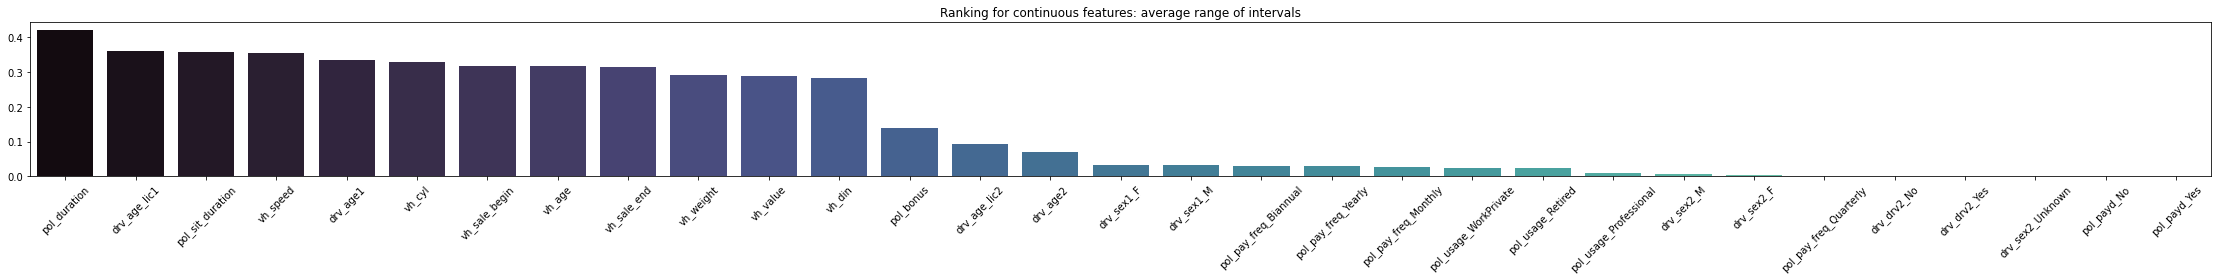

In [82]:
from discrepancies import discrepancies_intervals
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
print(len(intervals))

from discrepancies import analysis_global_reg

gda = analysis_global_reg.GlobalDiscrepancyAnalyzer(p2g, pool1, intervals, X_train, categorical_names=[])

import seaborn as sns
from matplotlib import pyplot as plt

feat_imp = gda.get_global_discrepancy_importances(min_expo=10)
#fname = '../../results/feature_importances_adult.pdf'
gda.plot_feature_importances(palettes=['mako', 'mako'])#, savefig='')

In [135]:
%load_ext autoreload

%autoreload 2
from discrepancies import analysis_global_reg


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
gda.get_discrepancy_segments(X_exposition=X_train, y_exposition=y_train, min_expo=0.05, min_purity=0.5, min_purity_expo=0.0)




Discrepancy segments tree EDR on nodes: nan
... on exposition data -inf
====== SEGMENT 7 ======
=== Segment description:
decision node 0 : vh_sale_begin <= 0.3649033457040787)
decision node 1 : vh_sale_begin <= -0.019442042335867882)
decision node 2 : pol_usage_Retired <= -0.42450933158397675)
decision node 3 : vh_age <= -0.3143817186355591)
decision node 4 : vh_din <= 1.1286574006080627)
decision node 5 : pol_sit_duration <= -0.31209060549736023)
decision node 6 : vh_age <= -1.0638937950134277)
=== Segment characteristics
Segment exposition: 0.0556966618287373
Segment node population (proxy for size?): 0.04077432001960304
Percent of the discrepancy nodes contained here: 0.0002796029637914162
Segment purity: 0.5252403846153846
Segment purity (X_expo): 0.5211726384364821
Accuracy of classifiers (EDR on X_expo) on segment: {'gamma': nan, 'spline': nan}
Number of discrepancy segments found: 1


<AxesSubplot:>

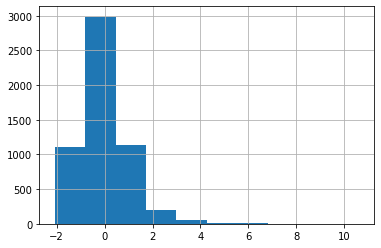

a

In [ ]:
path = "http://grarivincent.com/research/db4ModelFull2.csv"
input_data = (pd.read_csv(path, #names=column_names,
                            sep=r',', engine='python', na_values=['NA']))
input_data=input_data.drop(columns=['Unnamed: 0'])

base=baseINSEE
base = base[~base.pol_insee_code.str[:2].isin(["2A","2B"])]
base["pol_insee_code"] = base["pol_insee_code"].astype(int)
base_nd =  base.drop_duplicates(subset=['pol_insee_code'])

input_data = input_data.drop_duplicates()
input_data = input_data[~input_data.pol_insee_code.str[:2].isin(["2A","2B"])]
input_data["pol_insee_code"] = input_data["pol_insee_code"].astype(int)

input_data = input_data.merge(base_nd, how='inner', on="pol_insee_code")
X0_f = input_data.iloc[:, 4:31]

X_f = (X0_f
      .drop(columns=['pol_coverage','pol_insee_code'])
      .fillna('Unknown').pipe(pd.get_dummies))

G= G.iloc[:, :-5]
X_train, X_test, y_train, y_test, G_train, G_test, E_train, E_test, I_train, I_test  = train_test_split(X, y, G, E, I, test_size=0.2, random_state=7)

In [ ]:
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler)
X_f = X_f.pipe(scale_df, scaler)

scalerg = StandardScaler().fit(G_train)
scale_df_g = lambda df, scalerg: pd.DataFrame(scalerg.transform(df), columns=df.columns, index=df.index)
G_train = G_train.pipe(scale_df_g, scalerg) 
G_test = G_test.pipe(scale_df_g, scalerg)

y_traint =np.expand_dims(y_train,axis=1)
y_testt =np.expand_dims(y_test,axis=1)

### GLM Poisson sans zonier

In [ ]:
# ICI il n'y a que des expsures en 1 d'ou l'offset (log(expo)) non présent 
from sklearn import linear_model
clf = linear_model.PoissonRegressor() 
clf.fit(X_train,y_train)

In [ ]:
def EDR_POIS(yhat, y):
    #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
    #loss=torch.mean(yhat-y*torch.log(yhat))
    eps=0.000000000001
    res=1-np.mean((y*np.log((y+eps)/yhat)-(y-yhat)))/np.mean((y*np.log((y+eps)/np.mean(y))))
    return res

def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [ ]:
print(" GINI train : ", gini_coefficient(clf.predict(X_train)))
print(" GINI Poi test : ", gini_coefficient(clf.predict(X_test)))
print(" EDR POIS train : ", EDR_POIS(clf.predict(X_train),y_train))
print(" EDR POIS test : ", EDR_POIS(clf.predict(X_test),y_test))
MSE_Poi_tr =  ((clf.predict(X_train)-y_train)**2).mean()
MSE_Poi_test =  ((clf.predict(X_test)-y_test)**2).mean()
print(" MSE Poi train : ", MSE_Poi_tr)
print(" MSE Poi test : ", MSE_Poi_test)

In [ ]:
FREQ = clf.predict(X_train)
CM= reg.predict(X_train)

In [ ]:
X_final=input_data
X_final['FREQ'] = clf.predict(X_f)
X_final['CM'] = reg.predict(X_f)
X_final['PP'] = X_final['FREQ']*X_final['CM']